## OBJECTIVE : 

### Prepare classification model for classifying comments into various categories : toxic, severe_toxic, obscene, threat, insult, identity_hate

In [1]:
import warnings
warnings.simplefilter("ignore")

In [2]:
import os
import sys
import ipdb
import numpy as np
import pandas as pd

print("Numpy Version : ", np.__version__)
print("Pandas Version : ", pd.__version__)

np.random.seed(42)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

print("Matplotlib Version : ", mpl.__version__)

Numpy Version :  1.18.2
Pandas Version :  1.0.3
Matplotlib Version :  3.2.1


In [63]:
from joblib import load
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D, LSTM, GlobalMaxPool1D, Bidirectional
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout, AlphaDropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import SGD, Nadam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score

In [4]:
sys.path.insert(0, os.path.abspath(os.path.join("..")))

In [5]:
import utils.text_processing as tp
from config import GLOVE_PATH, MAX_VOCAB_SIZE, MAX_SEQUENCE_LENGTH, EMBEDDING_DIM, VALIDATION_SPLIT, BATCH_SIZE, EPOCHS

In [6]:
DATA_DIR = "../data/"
OBJECT_DIR = "../objects/"
LOG_DIR = "../logs/"

In [7]:
TRAIN_DIR = os.path.join(DATA_DIR, "training_data/word_2_index/")

In [8]:
CLASSES = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

In [9]:
train_data = pd.read_csv(os.path.join(TRAIN_DIR, "vectors_complex.csv"), encoding="utf-8")

In [10]:
train_data.head()

,0,1,2,3,4,5,6,7,8,9,...,96,97,98,99,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0,0,0,0,0,0,0,0,0,0,...,2,2058,16,15,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,697,9,4,91,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,218,571,76,302,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,17,1,680,2996,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,2140,677,371,2,0,0,0,0,0,0


In [11]:
X = train_data[[str(i) for i in np.arange(0, 100, 1)]].values
y = train_data[CLASSES].values

In [12]:
X.shape, y.shape

((159356, 100), (159356, 6))

In [13]:
X

array([[   0,    0,    0, ..., 2058,   16,   15],
       [   0,    0,    0, ...,    9,    4,   91],
       [   0,    0,    0, ...,  571,   76,  302],
       ...,
       [   0,    0,    0, ..., 2029, 9403, 2902],
       [   0,    0,    0, ...,  189,   18,   27],
       [   0,    0,    0, ...,  206,   30,  958]])

In [14]:
y

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [15]:
tokenizer = load(os.path.join(OBJECT_DIR, "tokenizer.joblib"))

In [16]:
word_ind_dict = tokenizer.word_index

In [17]:
GLOVE_PATH = "/home/praveen/pk_works/nlp/glove"
GLOVE_PATH = os.path.join(GLOVE_PATH, "glove.6B.{}d.txt".format(EMBEDDING_DIM))
GLOVE_PATH

'/home/praveen/pk_works/nlp/glove/glove.6B.100d.txt'

In [18]:
num_words = min(MAX_VOCAB_SIZE, len(word_ind_dict) + 1)

In [19]:
num_words

20000

In [20]:
len(word_ind_dict)

151081

In [21]:
embed_matrix = tp.get_embedding_matrix(GLOVE_PATH, word_ind_dict, num_words, EMBEDDING_DIM, MAX_VOCAB_SIZE)

In [22]:
embed_layer = tp.get_embedding_layer(num_words, EMBEDDING_DIM, embed_matrix, MAX_SEQUENCE_LENGTH)

In [23]:
embed_matrix.shape

(20000, 100)

In [24]:
embed_layer.get_config()

{'name': 'embedding',
 'trainable': False,
 'batch_input_shape': (None, 100),
 'dtype': 'float32',
 'input_dim': 20000,
 'output_dim': 100,
 'embeddings_initializer': {'class_name': 'RandomUniform',
  'config': {'minval': -0.05, 'maxval': 0.05, 'seed': None}},
 'embeddings_regularizer': None,
 'activity_regularizer': None,
 'embeddings_constraint': None,
 'mask_zero': False,
 'input_length': 100}

In [25]:
num_words, EMBEDDING_DIM, MAX_SEQUENCE_LENGTH

(20000, 100, 100)

In [97]:
def create_cnn_model():
    # train a 1D convnet with global maxpooling
    input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
    x = embed_layer(input_)
    x = Conv1D(128, 3, activation='relu', kernel_initializer="he_normal")(x)
    x = Dropout(0.40)(x)
    x = MaxPooling1D(3)(x)
#     x = Conv1D(128, 3, activation='selu', kernel_initializer="lecun_normal")(x)
#     x = AlphaDropout(0.45)(x)
#     x = MaxPooling1D(3)(x)
#     x = Conv1D(128, 3, activation='selu', kernel_initializer="lecun_normal")(x)
#     x = AlphaDropout(0.45)(x)
    x = GlobalMaxPooling1D()(x)
    x = Dense(128, activation='relu', kernel_initializer="he_normal")(x)
#     x = AlphaDropout(0.45)(x)
#     output = Dense(len(CLASSES), activation='sigmoid')(x)
    output = Dense(1, activation='sigmoid')(x)
    model = Model(input_, output)
    return model

In [80]:
# wavenet architecture
def create_cnn_dilation_model():
    model = Sequential()
    model.add(Input(shape=(MAX_SEQUENCE_LENGTH,)))
    model.add(embed_layer)
    for rate in (1, 2, 4, 8) * 2:
        model.add(Conv1D(filters=20, kernel_size=2, padding="causal", 
                         activation="relu", kernel_initializer="he_normal", dilation_rate=rate))
        model.add(Dropout(0.35))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(128, activation='relu', kernel_initializer="he_normal"))
    model.add(Dropout(0.45))
#     model.add(Dense(len(CLASSES), activation='sigmoid'))
    model.add(Dense(1, activation='sigmoid'))
    return model

In [58]:
def create_lstm_model():
    input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
    x = embed_layer(input_)
    x = LSTM(15, return_sequences=True)(x)
    x = GlobalMaxPool1D()(x)
    output = Dense(len(CLASSES), activation="sigmoid")(x)
    model = Model(input_, output)
    return model

In [115]:
def create_bidirectional_model():
    input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
    x = embed_layer(input_)
    x = Bidirectional(LSTM(15, return_sequences=True))(x)
    x = GlobalMaxPool1D()(x)
#     x = Bidirectional(LSTM(15, dropout=0.4, recurrent_dropout=0.4))(x)
    output = Dense(len(CLASSES), activation="sigmoid")(x)
    model = Model(input_, output)
    return model

In [98]:
model = create_cnn_model()

In [99]:
model.get_config()

{'name': 'model',
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 100),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'input_6'},
   'name': 'input_6',
   'inbound_nodes': []},
  {'class_name': 'Embedding',
   'config': {'name': 'embedding',
    'trainable': False,
    'batch_input_shape': (None, 100),
    'dtype': 'float32',
    'input_dim': 20000,
    'output_dim': 100,
    'embeddings_initializer': {'class_name': 'RandomUniform',
     'config': {'minval': -0.05, 'maxval': 0.05, 'seed': None}},
    'embeddings_regularizer': None,
    'activity_regularizer': None,
    'embeddings_constraint': None,
    'mask_zero': False,
    'input_length': 100},
   'name': 'embedding',
   'inbound_nodes': [[['input_6', 0, 0, {}]]]},
  {'class_name': 'Conv1D',
   'config': {'name': 'conv1d_40',
    'trainable': True,
    'dtype': 'float32',
    'filters': 128,
    'kernel_size': (3,),
    'strides': (1,),
    'padding': 'valid',
    '

In [100]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 100, 100)          2000000   
_________________________________________________________________
conv1d_40 (Conv1D)           (None, 98, 128)           38528     
_________________________________________________________________
dropout_35 (Dropout)         (None, 98, 128)           0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 32, 128)           0         
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 128)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)               16512 

In [101]:
model.compile(
  loss='binary_crossentropy',
  optimizer=Nadam(lr=0.001, beta_1=0.9, beta_2=0.999),
  metrics=['accuracy']
)

In [102]:
history = model.fit(
    X,
    y[:, 3],
    batch_size=BATCH_SIZE,
    epochs=50,
    validation_split=VALIDATION_SPLIT,
    callbacks=[EarlyStopping(patience=10)]
)

Train on 127484 samples, validate on 31872 samples
Epoch 1/50
127484/127484 [==============================] - 6s 44us/sample - loss: 0.0216 - accuracy: 0.9966 - val_loss: 0.0159 - val_accuracy: 0.9971
Epoch 2/50
127484/127484 [==============================] - 5s 37us/sample - loss: 0.0126 - accuracy: 0.9971 - val_loss: 0.0254 - val_accuracy: 0.9965
Epoch 3/50
127484/127484 [==============================] - 5s 37us/sample - loss: 0.0110 - accuracy: 0.9972 - val_loss: 0.0152 - val_accuracy: 0.9970
Epoch 4/50
127484/127484 [==============================] - 5s 37us/sample - loss: 0.0096 - accuracy: 0.9974 - val_loss: 0.0225 - val_accuracy: 0.9959
Epoch 5/50
127484/127484 [==============================] - 5s 37us/sample - loss: 0.0080 - accuracy: 0.9978 - val_loss: 0.0133 - val_accuracy: 0.9972
Epoch 6/50
127484/127484 [==============================] - 5s 37us/sample - loss: 0.0073 - accuracy: 0.9979 - val_loss: 0.0149 - val_accuracy: 0.9969
Epoch 7/50
127484/127484 [=================

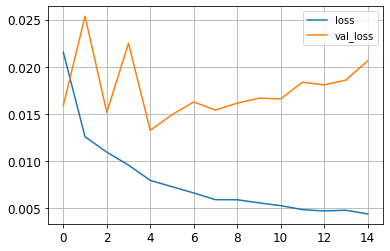

In [103]:
# plot some data
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.grid()
plt.show()

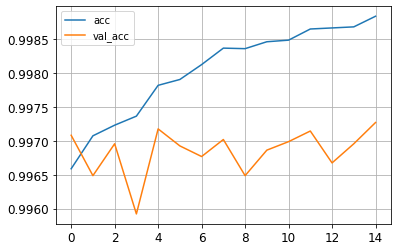

In [104]:
# accuracies
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.grid()
plt.show()

In [108]:
# For threat class only
p = model.predict(X)
p = np.where(p > 0.5, 1, 0)
print("Shape of predicted values : ", p.shape)
print("Shape of target values : ", y[:,3].shape)
tn, fp, fn, tp = confusion_matrix(y[:,3], p).ravel()
print("True neg : ", tn)
print("False pos : ", fp)
print("False neg : ", fn)
print("True pos : ", tp)
print()
print(classification_report(y[:,3], p))
print()
print("ROC : {}".format(roc_auc_score(y[:, 3], p)))
print()
print("Precision : {}".format(precision_score(y[:, 3], p)))
print()
print("Accuracy : {}".format(accuracy_score(y[:, 3], p)))
print()
print("Recall : {}".format(recall_score(y[:, 3], p)))
print()
print("F1 : {}".format(f1_score(y[:, 3], p)))
print()

Shape of predicted values :  (159356, 1)
Shape of target values :  (159356,)
True neg :  158838
False pos :  40
False neg :  127
True pos :  351

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    158878
           1       0.90      0.73      0.81       478

    accuracy                           1.00    159356
   macro avg       0.95      0.87      0.90    159356
weighted avg       1.00      1.00      1.00    159356


ROC : 0.867028928962677

Precision : 0.8976982097186701

Accuracy : 0.9989520319285122

Recall : 0.7343096234309623

F1 : 0.807825086306099



#### If training is done for all the classes

In [ ]:
# plot the mean AUC over each label
p = model.predict(X)
p = np.where(p > 0.5, 1, 0)
aucs = []
for j in range(6):
    auc = roc_auc_score(y[:,j], p[:,j])
    aucs.append(auc)
print("MEAN auc : ", np.mean(aucs))

In [73]:
for i in range(len(CLASSES)):
    print("For class : ", CLASSES[i])
    tn, fp, fn, tp = confusion_matrix(y[:,i], p[:,i]).ravel()
    print("True neg : ", tn)
    print("False pos : ", fp)
    print("False neg : ", fn)
    print("True pos : ", tp)
    print()

For class :  toxic
True neg :  143653
False pos :  410
False neg :  7363
True pos :  7930

For class :  severe_toxic
True neg :  157761
False pos :  0
False neg :  1595
True pos :  0

For class :  obscene
True neg :  150876
False pos :  31
False neg :  6386
True pos :  2063

For class :  threat
True neg :  158878
False pos :  0
False neg :  478
True pos :  0

For class :  insult
True neg :  151371
False pos :  108
False neg :  6578
True pos :  1299

For class :  identity_hate
True neg :  157951
False pos :  0
False neg :  1405
True pos :  0



In [37]:
for i in range(len(CLASSES)):
    print("For class : ", CLASSES[i])
    print(classification_report(y[:,i], p[:,i]))
    print()

For class :  toxic
              precision    recall  f1-score   support

           0       0.96      0.99      0.98    144063
           1       0.89      0.66      0.75     15293

    accuracy                           0.96    159356
   macro avg       0.93      0.82      0.87    159356
weighted avg       0.96      0.96      0.96    159356


For class :  severe_toxic
              precision    recall  f1-score   support

           0       0.99      1.00      1.00    157761
           1       0.67      0.13      0.22      1595

    accuracy                           0.99    159356
   macro avg       0.83      0.56      0.61    159356
weighted avg       0.99      0.99      0.99    159356


For class :  obscene
              precision    recall  f1-score   support

           0       0.98      0.99      0.99    150907
           1       0.87      0.72      0.79      8449

    accuracy                           0.98    159356
   macro avg       0.93      0.86      0.89    159356
weight

In [38]:
for i in range(len(CLASSES)):
    print("ROC for CLASS : {} is {}.".format(CLASSES[i], roc_auc_score(y[:, i], p[:, i])))

ROC for CLASS : toxic is 0.8231921649429097.
ROC for CLASS : severe_toxic is 0.5639368797199861.
ROC for CLASS : obscene is 0.8584345398050113.
ROC for CLASS : threat is 0.5.
ROC for CLASS : insult is 0.7256272400041394.
ROC for CLASS : identity_hate is 0.5.


In [39]:
for i in range(len(CLASSES)):
    print("Precision for CLASS : {} is {}.".format(CLASSES[i], precision_score(y[:, i], p[:, i])))

Precision for CLASS : toxic is 0.8896882494004796.
Precision for CLASS : severe_toxic is 0.6655844155844156.
Precision for CLASS : obscene is 0.8698376530902877.
Precision for CLASS : threat is 0.0.
Precision for CLASS : insult is 0.8256374913852516.
Precision for CLASS : identity_hate is 0.0.


In [40]:
for i in range(len(CLASSES)):
    print("Recall for CLASS : {} is {}.".format(CLASSES[i], recall_score(y[:, i], p[:, i])))

Recall for CLASS : toxic is 0.6550055580984764.
Recall for CLASS : severe_toxic is 0.12852664576802508.
Recall for CLASS : obscene is 0.7229257900343236.
Recall for CLASS : threat is 0.0.
Recall for CLASS : insult is 0.4562650755363717.
Recall for CLASS : identity_hate is 0.0.


In [41]:
for i in range(len(CLASSES)):
    print("Accuracy for CLASS : {} is {}.".format(CLASSES[i], accuracy_score(y[:, i], p[:, i])))

Accuracy for CLASS : toxic is 0.9590978689224127.
Accuracy for CLASS : severe_toxic is 0.9906310399357413.
Accuracy for CLASS : obscene is 0.9795740354928587.
Accuracy for CLASS : threat is 0.9970004267175381.
Accuracy for CLASS : insult is 0.9683601496021487.
Accuracy for CLASS : identity_hate is 0.9911832626320942.
